# Predicting house sale prices

This project aims to predict the sale prices of houses in the city of Ames, Iowa, United States. We will use data from 2006 to 2010. You can read more about why the data was collected [here](https://doi.org/10.1080/10691898.2011.11889627). You can also read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Import data

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold


In [2]:
# Import the dataset
houses = pd.read_csv('AmesHousing.txt', delimiter="\t")
houses.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
# Define the targe column
target = 'SalePrice'

# Calculate the mean sale price
mean_price = houses[target].mean()

print("The average house price is ${:.0f}".format(mean_price))

The average house price is $180796


## Data cleaning

For handling the missing values at this stage, we will:
* Remove any column with 5% or more missing values
* Remove any text column with missing values
* Fill in the missing values of numerical columns with the average value

In [4]:
# Remove any column with 5% or more missing values
houses = houses.loc[:,houses.isnull().sum() / houses.shape[0] < 0.05 ]

# Remove any text column with missing values
houses = houses.loc[:,~((houses.dtypes == 'object') & (houses.isnull().any()))]

# Fill in the missing values of numerical columns with the average value
num_cols = houses.select_dtypes('number').columns

houses[num_cols] = houses[num_cols].fillna(houses[num_cols].mean())

# Count missing values
houses.isnull().sum().sum()

0

Now we will drop columns that:
* That are not useful for predicting the target.
* Leak data about the final sale.

In [5]:
## Drop columns that are not useful for predicting the target
houses = houses.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
houses = houses.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

## Initial prediction

We will use ordinary least squares linear regression ins this project. The target column is `SalePrice`. For the initial estimation, we will use the feature that has the highest correlation with the target.

In [6]:
num_cols = houses.select_dtypes('number').columns

houses[num_cols].corr()['SalePrice'].abs().sort_values(ascending=False)[1:6]

Overall Qual     0.799262
Gr Liv Area      0.706780
Garage Cars      0.647861
Garage Area      0.640385
Total Bsmt SF    0.632105
Name: SalePrice, dtype: float64

The feature `Overall Qual` has the highest correlation with the target.

In [7]:
features = ['Overall Qual']

# Divide into training and test sets using equal proportions
train = houses[0:1460].copy()
test = houses[1460:].copy()

# Instantiate ordinary least squares linear regression model
lr = LinearRegression()

# Fit the model using the training data and target values
lr.fit(train[features], train[target])

# Predict the target for the test data
predictions  = lr.predict(test[features])

# Calculate the root mean squared error
rmse = np.sqrt(mean_squared_error(test[target], predictions))

print("The average house price is ${:.0f}, and the Root Mean Square Error (RMSE) is ${:.0f} ({:.1f}% of the average price).".format(mean_price, rmse, rmse / mean_price * 100))

The average house price is $180796, and the Root Mean Square Error (RMSE) is $49492 (27.4% of the average price).


## Feature selection

We will now look at the correlation between each numerical feature and the target. We will only consider features that have a correlation coefficient greater than 0.2.

In [8]:
num_cols = houses.select_dtypes('number').columns

features_corr = houses[num_cols].corr()['SalePrice'].abs().sort_values(ascending=False)[1:]
features_corr = features_corr[features_corr > 0.2]
print(features_corr)

num_features = features_corr.index.values

Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647861
Garage Area       0.640385
Total Bsmt SF     0.632105
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Mas Vnr Area      0.505784
TotRms AbvGrd     0.495474
Fireplaces        0.474558
BsmtFin SF 1      0.432794
Wood Deck SF      0.327143
Open Porch SF     0.312951
Half Bath         0.285056
Bsmt Full Bath    0.275894
2nd Flr SF        0.269373
Lot Area          0.266549
Name: SalePrice, dtype: float64


In [9]:
def train_test_model_1(train, test, features):

    # Instantiate ordinary least squares linear regression model
    lr = LinearRegression()

    # Fit the model using the training data and target values
    lr.fit(train[features], train[target])

    # Predict the target for the test data
    predictions  = lr.predict(test[features])

    # Calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    
    return rmse

Text(0, 0.5, 'Root mean squared error')

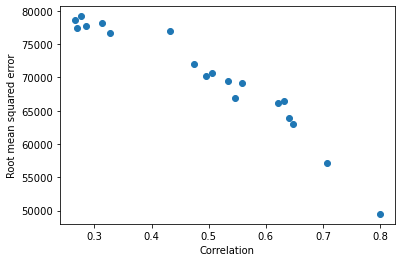

In [10]:
# Divide into training and test sets using equal proportions
train = houses[0:1460].copy()
test = houses[1460:].copy()

# Train ans test the model for each feature
rmses = [train_test_model_1(train, test, [feature]) for feature in num_features]
rmses = pd.Series(rmses, index=features_corr.index)

# Plot the RMSE
plt.scatter(features_corr, rmses)
plt.xlabel("Correlation")
plt.ylabel("Root mean squared error")

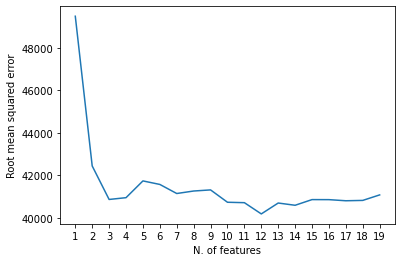

In [11]:
n_features = range(1,len(num_features) + 1)

rmses = [train_test_model_1(train, test, num_features[:n]) for n in n_features]

plt.plot(n_features, rmses)
plt.xlabel("N. of features")
plt.ylabel("Root mean squared error")
plt.xticks(n_features);

Using the twelve features with the highest correlation lead to the lowest error.

In [12]:
num_features = num_features[:12]
num_features

array(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath',
       'Year Remod/Add', 'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces'],
      dtype=object)

Regarding the categorical features, we will select those that do not lead to a high Root Mean Square Error (RMSE). We need to convert them into dummy/indicator variables to use them in the linear regression model.

In [13]:
cat_cols = ["MS SubClass", "MS Zoning", "Street", "Land Contour", "Lot Config", "Neighborhood", "Condition 1", "Condition 2",
            "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Foundation", "Heating",
            "Central Air"]

In [14]:
def train_test_model_2(df, feature_name):

    # Instantiate ordinary least squares linear regression model
    lr = LinearRegression()

    # Create DataFrame with target and converted feature
    df_converted = pd.concat([df[target], pd.get_dummies(df[feature_name].astype('category'))], axis=1)
    
    # Divide into training and test sets using equal proportions
    train = df_converted[0:1460].copy()
    test = df_converted[1460:].copy()

    # Fit the model using the training data and target values
    lr.fit(train.iloc[:,1:], train.iloc[:,0])

    # Predict the target for the test data
    predictions  = lr.predict(test.iloc[:,1:])

    # Calculate the root mean squared error
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    
    return rmse

In [15]:
cat_features = cat_cols

rmses = [train_test_model_2(houses, feature) for feature in cat_features]

cat_features = np.array(cat_features)[np.array(rmses) < 100000]
cat_features

array(['MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Foundation', 'Heating', 'Central Air'],
      dtype='<U12')

## Final prediction

In [16]:
# Create DataFrame with numerical features, converted categorical features and target
df = houses[num_features].copy()

for col in cat_features:

    df = pd.concat([df, pd.get_dummies(houses[col].astype('category'))], axis=1)

features = df.columns
    
df[target] = houses[target]

In [17]:
# Instantiate ordinary least squares linear regression model
lr = LinearRegression()

# Performe K-Fold cross validation (using 5 folds)
kf = KFold(5, shuffle=True, random_state=1)

rmses = cross_val_score(lr, df[features], df[target], scoring="neg_root_mean_squared_error", cv=kf)
rmse = abs(rmses).mean()

print("The average house price is ${:.0f}, and the Root Mean Square Error (RMSE) is ${:.0f} ({:.1f}% of the average price).".format(mean_price, rmse, rmse / mean_price * 100))

The average house price is $180796, and the Root Mean Square Error (RMSE) is $33872 (18.7% of the average price).
